# Classification of rib fracture types from postmortem computed tomography images using deep learning

This notebook was created by Victor Ibañez for a project led by Akos Dobay at ForMaLTec, Institute of Forensic Medicine, University of Zurich. The goal is to train a model to classify different rib fracture types. The dataset was labeled by Dario Jucker and Sabine Franckenberg and further processed by Victor Ibañez.

## Import libraries

In [1]:
import os
import glob
import random
import math
import shutil
import numpy as np
from natsort import natsorted

In [2]:
source_dir = 'data_21102022'
target_dir = 'data_21102022_ready'

## Create single dataset

Here we first want to create a split from our dataset for training, (validation) and testing.

In [3]:
classes = os.listdir(source_dir)
if '.DS_Store' in classes:
    classes.remove('.DS_Store')
classes = natsorted(classes)
print(classes)

['displaced_latus', 'displaced_long_cum_cont', 'displaced_long_cum_dist', 'no_fracture', 'nondisplaced']


In [4]:
def create_images(cand_pack, imgsave_path, file_prefix):

    '''function that copies the images from the source 
    to the target folder in the right way'''
    
    cnt = 1
    cand_unpack = [item for sublist in cand_pack for item in sublist]

    for filename in cand_unpack:

        #new_filename = os.path.join(imgsave_path, '{0}_{1}.jpg'.format(file_prefix, cnt))
        new_filename = os.path.join(imgsave_path, filename)
        filepath = os.path.join(source_dir,file_prefix,filename)
        shutil.copy(filepath, new_filename)

        cnt += 1


In [5]:
def pack(candidates):
    
    '''function that creates "packages of augmented fracture data" 
    that correspond to one single fracture. This is done to make sure
    that there is no data leakage into the validation and test set.'''

    cand_pack = []
    fracture = []
    
    for c in range(len(candidates)-1):
        
        name = candidates[c].split('.')[0].split('_')[-2]
        name2 = candidates[c+1].split('.')[0].split('_')[-2]
        
        if c == len(candidates)-2:
            fracture.append(candidates[c])
            fracture.append(candidates[c+1])
            cand_pack.append(fracture)
            fracture = []
            
        if int(name) < int(name2):
            fracture.append(candidates[c])
            
        else:
            fracture.append(candidates[c])
            cand_pack.append(fracture)
            fracture = []
            
    return cand_pack
            
        

In [6]:
def process(dist_training, dist_validation, dist_test, use_val):
    
    '''function to split data into train, (validation) 
    and test set according to a predefined percentage'''
    
    if (dist_training + dist_validation + dist_test) != 100:
        print(f'Error! numbers are not equal to 100 %: training: {dist_training}, validation: {dist_validation}, test: {dist_test}') 
    if use_val == True:
        distributions = {'training': dist_training, 'validation': dist_validation, 'test': dist_test}
    elif use_val != True:
        distributions = {'training': dist_training, 'test': dist_test}  

    for cl in classes:
        
        print('current class:',cl)
        
        candidates = natsorted(os.listdir(os.path.join(source_dir, cl)))
        if '.DS_Store' in candidates:
            candidates = candidates[1:]
            
        cand_pack = pack(candidates)
    
        offset = 0
        
        for key, percentage in distributions.items(): 
            
            share = math.floor(len(cand_pack) / 100 * percentage)
  
            class_path = os.path.join(target_dir, key, cl)
            if not os.path.isdir(class_path): 
                os.makedirs(class_path)
    
            create_images(cand_pack[offset:offset+share], class_path, cl)

            offset += share

In [5]:
process(70,0,30, use_val=True) # call function; value 1: training %, value 2: validation %, value 3: test %. (numbers have to add up to 100%, if not using val, val = 0)

NameError: name 'classes' is not defined

## create cross validation data

If using cross validation we further produce k splits from the training data (given no validation data was produced above!).

In [60]:
sets = ['training','validation']
k_fold = 5
partitions = k_fold
source_dir = 'data_21102022_ready/data_all/training'

In [61]:
def iter_obj(cl):
    
    '''function that iterates on object'''
    
    print('current class:',cl)

    candidates = natsorted(os.listdir(os.path.join(source_dir, cl)))
    if '.DS_Store' in candidates:
        candidates = candidates[1:]

    cand_pack = pack(candidates)

    len_iter_pack = math.floor(len(cand_pack)/partitions)

    rest = len(cand_pack) % len_iter_pack

    to_iter = []

    for cand in range(len(cand_pack)):

        if cand % len_iter_pack == 0 and (cand+len_iter_pack) <= len(cand_pack):
            to_iter.append(cand_pack[cand:cand+len_iter_pack])
        elif cand % len_iter_pack == 0 and (cand+len_iter_pack) >= len(cand_pack):
            # fill rest into k-sets backwards 
            for r in range(rest,0,-1): 
                to_iter[-r].append(cand_pack[-r])
    
    return to_iter
        


In [62]:
def main():
    
    '''function that produces k splits and stores data in k folders'''
    
    all_data = []
    
    for cl in classes:
        to_iter = iter_obj(cl)
        all_data.append(to_iter)
      
    if not os.path.isdir(target_dir): 
        os.makedirs(target_dir)
      
    for i in range(1,k_fold+1):   
        
        name = 'iter_'
        iter_path = os.path.join(target_dir, name + str(i))
        if not os.path.isdir(iter_path): 
            os.makedirs(iter_path)
        
        training_set = list(range(5))
        #test_set = [(i+(i-1))-1]
        validation_set = [i-1]
        #validation_set = [i+(i-1)]
        #training_set.remove(test_set[0])
        training_set.remove(validation_set[0])
        distribution = [training_set,validation_set]  #,test_set
        
        for s in range(len(sets)):
            set_path = os.path.join(iter_path, sets[s])
            if not os.path.isdir(set_path): 
                os.makedirs(set_path)
            current_distribution = distribution[s]
            
            for cl in range(len(classes)):
                class_path = os.path.join(set_path, classes[cl])
                if not os.path.isdir(class_path): 
                    os.makedirs(class_path)
                for parts in current_distribution:
                    create_images(all_data[cl][parts],class_path,classes[cl])
                    

In [63]:
main() # function call

current class: displaced_latus
current class: displaced_long_cum_cont
current class: displaced_long_cum_dist
current class: no_fracture
current class: nondisplaced


## train model in CV to tune hyperparameters

Now we want to train and evaluate a model. For this we use transfer learning on a ResNet50, pretrained on ImageNet. We first train the model with frozen layers for a few epochs and then unfreeze the layers and fine-tune the model with a smaller learning rate.

In [7]:
# import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam

In [8]:
# USE THIS ON A WINDOWS COMPUTER
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.InteractiveSession(config=config)

In [9]:
source_dir = 'data_21102022'
#target_dir = r'C:\Users\vibane\Desktop\Victor\Victor_ML\data_21102022_ready\data_all'
#mod_name = 'ResNet50_data_all'

In [10]:
train_data_dir = os.path.join(target_dir, 'training')
validation_data_dir = os.path.join(target_dir, 'validation')
test_data_dir = os.path.join(target_dir, 'test')

In [11]:
# extract image size

im = Image.open(os.path.join(source_dir, classes[0], os.listdir(os.path.join(source_dir,classes[0]))[1]))
img_width, img_height = im.size
print(im)

print('your images are of size: ', img_height, img_width, '3')

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=99x99 at 0x26A8B52AFC8>
your images are of size:  99 99 3


In [12]:
# extract amount of training and validation data

t_l = 0
v_l = 0

for cl in classes:
    t_l += len(os.listdir(os.path.join(train_data_dir,cl)))
    v_l += len(os.listdir(os.path.join(validation_data_dir,cl)))
print('total training data:', t_l, 'total validation data:', v_l)


"\nt_l = 0\nv_l = 0\n\nfor cl in classes:\n    t_l += len(os.listdir(os.path.join(train_data_dir,cl)))\n    v_l += len(os.listdir(os.path.join(validation_data_dir,cl)))\nprint('total training data:', t_l, 'total validation data:', v_l)\n"

In [13]:
# extract weights
    
cnt_list = []
for cl in classes:
    cnt_list.append(len(os.listdir(os.path.join(source_dir,cl))))

w_list = []
total = sum(cnt_list)
for i in cnt_list:
    w_list.append((1 / i)*(total)/len(cnt_list)) 

weights = {}
for i in range(len(w_list)):
    weights[i] = w_list[i]

print('weight distribution among classes:',weights)


weight distribution among classes: {0: 6.772116461366181, 1: 1.7781534842693325, 2: 3.81064902331443, 3: 0.399821493504347, 4: 0.6551294550969559}


In [14]:
# set input shape
input_shape = (img_height, img_width, 3)

In [15]:
def f1_weighted(y_true, y_pred):
    
    y_true = np.argmax(y_true.numpy(), axis=1).flatten()
    y_pred = np.argmax(y_pred.numpy(), axis=1).flatten()
    F1 = f1_score(y_true, y_pred, average='weighted')
    
    return F1

In [16]:
def f1_macro(y_true, y_pred):
    
    y_true = np.argmax(y_true.numpy(), axis=1).flatten()
    y_pred = np.argmax(y_pred.numpy(), axis=1).flatten()
    F1 = f1_score(y_true, y_pred, average='macro')
    
    return F1

In [17]:
def ind_f_score(p,r,B):
    
    F_score = (1+B**2)*((p*r))/(((B**2)*p)+r)
    
    return F_score

In [18]:
def f_final(f_list,w_c1,w_c2,w_c3):
    
    f1 = ((f_list[0]*w_c1)+(f_list[1]*w_c2)+(f_list[2]*w_c3))/(w_c1+w_c2+w_c3)
    
    return f1

In [19]:
def f1_adjusted(y_true, y_pred):
    
    y_true = np.argmax(y_true.numpy(), axis=1).flatten()
    y_pred = np.argmax(y_pred.numpy(), axis=1).flatten()
    p_r = precision_recall_fscore_support(y_true, y_pred, average=None,labels=[0, 1, 2])
    f_list = [ind_f_score(p_r[0][0],p_r[1][0],0.9),ind_f_score(p_r[0][1],p_r[1][1],1.2),ind_f_score(p_r[0][2],p_r[1][2],0.9)]
    f_list = [0 if x != x else x for x in f_list]
    f1 = f_final(f_list,p_r[3][0],p_r[3][1],p_r[3][2])
    
    return f1

In [20]:
from sklearn.metrics import precision_recall_fscore_support
def pre_rec_f(y_true, y_pred):
    y_true = np.argmax(y_true.numpy(), axis=1).flatten()
    y_pred = np.argmax(y_pred.numpy(), axis=1).flatten()
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred,average='macro')
    
    return p,r,f

In [21]:
def custom_loss_function(y_true, y_pred):
    
    # scale predictions so that the class probas of each sample sum to 1
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = y_true * K.log(y_pred) * weights
    loss = -K.sum(loss, -1)
    
    return loss

In [19]:
# set parameter
epochs = 100
batch_size = 64

nclasses = len(classes)
loss_type = 'categorical_crossentropy' 
class_type = 'categorical' 
activation_fun = 'softmax' 
learning_rate = 0.00015
dropout_rate = 0.5
early_patience = 10
layer_size = 99*2

exp_name = f'CV_ls_{layer_size}_bs_{batch_size}_lr_{learning_rate}_dr_{dropout_rate}_ep_{epochs}_pat_{early_patience}'

reduce_lr1 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000005)
early1 = EarlyStopping(monitor='val_loss', patience=early_patience, verbose=1, mode='min')

reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000005)
early2 = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

#import tensorflow.keras.backend as K
#weights = np.array([0.4,0.25,0.35])
#weights = K.variable(weights)

In [21]:
# merge callbacks
callbacks1 = [early1, reduce_lr1]
callbacks2 = [early2, reduce_lr2]

partition: 1
Found 33910 images belonging to 5 classes.
Found 8240 images belonging to 5 classes.
{'displaced_latus': 0, 'displaced_long_cum_cont': 1, 'displaced_long_cum_dist': 2, 'no_fracture': 3, 'nondisplaced': 4}
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 530 steps, validate for 129 steps
Epoch 1/100
530/530 [==============================] - 160s 301ms/step - loss: 0.8862 - precision: 0.7976 - recall: 0.6157 - f1_weighted: 0.7240 - f1_macro: 0.5854 - f1_adjusted: 0.5586 - val_loss: 12.3803 - val_precision: 0.5138 - val_recall: 0.5138 - val_f1_weighted: 0.3517 - val_f1_macro: 0.1416 - val_f1_adjusted: 0.0000e+00
Epoch 2/100
530/530 [==============================] - 156s 295ms/step - loss: 0.2992 - precision: 0.9099 - recall: 0.8700 - f1_weighted: 0.8951 - f1_macro: 0.8312 - f1_adjusted: 0.8460 - val_loss: 3.4348 - val_precision: 0.7269 - val_recall: 0.7186 - val_f1_weighted: 0.6864 - val_

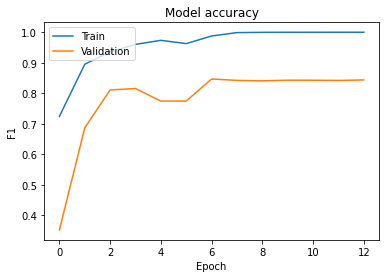

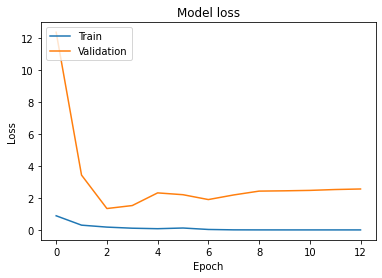

partition: 2
Found 33756 images belonging to 5 classes.
Found 8394 images belonging to 5 classes.
{'displaced_latus': 0, 'displaced_long_cum_cont': 1, 'displaced_long_cum_dist': 2, 'no_fracture': 3, 'nondisplaced': 4}
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 528 steps, validate for 132 steps
Epoch 1/100
528/528 [==============================] - 159s 300ms/step - loss: 0.7970 - precision: 0.8257 - recall: 0.6562 - f1_weighted: 0.7564 - f1_macro: 0.6245 - f1_adjusted: 0.6095 - val_loss: 12.8111 - val_precision: 0.5044 - val_recall: 0.5044 - val_f1_weighted: 0.3430 - val_f1_macro: 0.1415 - val_f1_adjusted: 0.0000e+00
Epoch 2/100
528/528 [==============================] - 157s 297ms/step - loss: 0.2544 - precision: 0.9239 - recall: 0.8857 - f1_weighted: 0.9084 - f1_macro: 0.8535 - f1_adjusted: 0.8689 - val_loss: 1.7842 - val_precision: 0.7567 - val_recall: 0.7028 - val_f1_weighted: 0.7199 - val_f1_macro: 0.4986 - val_f1_adjusted: 0.3766
Epoch 3/100
528/528 [============

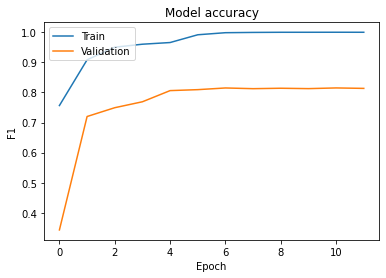

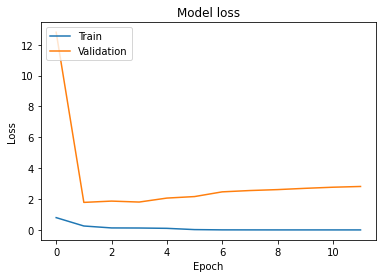

partition: 3
Found 33709 images belonging to 5 classes.
Found 8441 images belonging to 5 classes.
{'displaced_latus': 0, 'displaced_long_cum_cont': 1, 'displaced_long_cum_dist': 2, 'no_fracture': 3, 'nondisplaced': 4}
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 527 steps, validate for 132 steps
Epoch 1/100
527/527 [==============================] - 158s 300ms/step - loss: 0.8745 - precision: 0.8162 - recall: 0.6263 - f1_weighted: 0.7379 - f1_macro: 0.5884 - f1_adjusted: 0.5681 - val_loss: 12.5846 - val_precision: 0.5018 - val_recall: 0.5018 - val_f1_weighted: 0.3374 - val_f1_macro: 0.1393 - val_f1_adjusted: 0.0000e+00
Epoch 2/100
527/527 [==============================] - 156s 297ms/step - loss: 0.3037 - precision: 0.9125 - recall: 0.8688 - f1_weighted: 0.8969 - f1_macro: 0.8234 - f1_adjusted: 0.8454 - val_loss: 2.0690 - val_precision: 0.7857 - val_recall: 0.7492 - val_f1_weighted: 0.7517 - val_f1_macro: 0.5258 - val_f1_adjusted: 0.4446
Epoch 3/100
527/527 [============

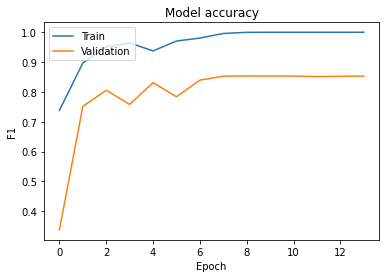

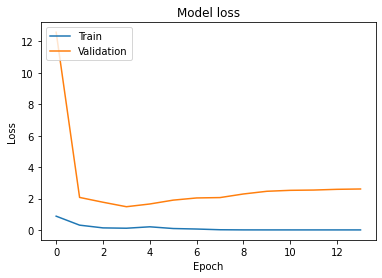

partition: 4
Found 33620 images belonging to 5 classes.
Found 8531 images belonging to 5 classes.
{'displaced_latus': 0, 'displaced_long_cum_cont': 1, 'displaced_long_cum_dist': 2, 'no_fracture': 3, 'nondisplaced': 4}
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 526 steps, validate for 134 steps
Epoch 1/100
526/526 [==============================] - 158s 301ms/step - loss: 0.8769 - precision: 0.7971 - recall: 0.6220 - f1_weighted: 0.7267 - f1_macro: 0.5801 - f1_adjusted: 0.5606 - val_loss: 11.7742 - val_precision: 0.4967 - val_recall: 0.4967 - val_f1_weighted: 0.3316 - val_f1_macro: 0.1380 - val_f1_adjusted: 0.0000e+00
Epoch 2/100
526/526 [==============================] - 156s 297ms/step - loss: 0.3138 - precision: 0.9039 - recall: 0.8570 - f1_weighted: 0.8873 - f1_macro: 0.8164 - f1_adjusted: 0.8345 - val_loss: 1.6534 - val_precision: 0.8039 - val_recall: 0.7654 - val_f1_weighted: 0.7723 - val_f1_macro: 0.5709 - val_f1_adjusted: 0.4997
Epoch 3/100
526/526 [============

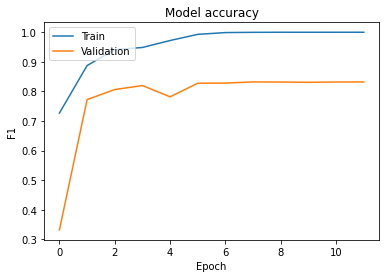

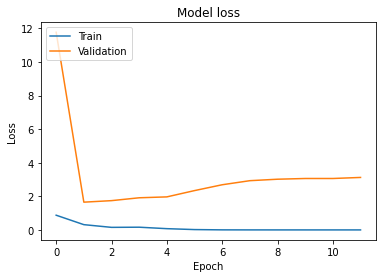

partition: 5
Found 33606 images belonging to 5 classes.
Found 8545 images belonging to 5 classes.
{'displaced_latus': 0, 'displaced_long_cum_cont': 1, 'displaced_long_cum_dist': 2, 'no_fracture': 3, 'nondisplaced': 4}
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 526 steps, validate for 134 steps
Epoch 1/100
526/526 [==============================] - 158s 300ms/step - loss: 0.8611 - precision: 0.8077 - recall: 0.6297 - f1_weighted: 0.7375 - f1_macro: 0.6005 - f1_adjusted: 0.5847 - val_loss: 9.2986 - val_precision: 0.4956 - val_recall: 0.4956 - val_f1_weighted: 0.3304 - val_f1_macro: 0.1393 - val_f1_adjusted: 0.0000e+00
Epoch 2/100
526/526 [==============================] - 156s 297ms/step - loss: 0.2760 - precision: 0.9150 - recall: 0.8742 - f1_weighted: 0.8998 - f1_macro: 0.8350 - f1_adjusted: 0.8601 - val_loss: 4.7717 - val_precision: 0.6242 - val_recall: 0.6158 - val_f1_weighted: 0.5467 - val_f1_macro: 0.3142 - val_f1_adjusted: 0.1455
Epoch 3/100
526/526 [=============

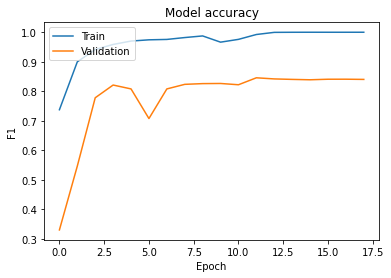

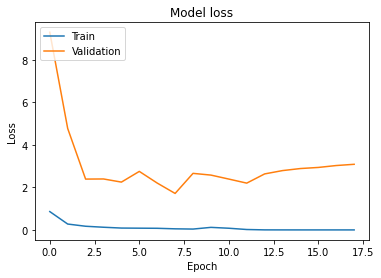

In [22]:
import warnings
warnings.filterwarnings('ignore')

root_path = 'data_21102022_ready'
exp_path = os.path.join(root_path,'experiments')
save_path = os.path.join(exp_path,exp_name)

if not os.path.isdir(save_path): 
    os.makedirs(save_path)
    
partition = 0

for fold in range(5):
    
    print(f'partition: {fold+1}')
    
    # USE THIS FOR WINDOWS
    #config = tf.compat.v1.ConfigProto()
    #config.gpu_options.allow_growth = True
    #sess = tf.compat.v1.InteractiveSession(config=config)
    
    current_iter_path = os.path.join(root_path,f'iter_{fold+1}')
    current_training = os.path.join(current_iter_path,'training')
    current_validation = os.path.join(current_iter_path,'validation')
    mod_name = f'ResNet50_{fold+1}'
    
    nb_train_samples = len(os.listdir(current_training))
    nb_validation_samples = len(os.listdir(current_validation))
    
    train_datagen = ImageDataGenerator(rescale=1. / 255)
    validation_datagen = ImageDataGenerator(rescale=1. / 255)
    
    train_generator = train_datagen.flow_from_directory(
        current_training,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=class_type)
    print(train_generator)

    validation_generator = validation_datagen.flow_from_directory(
        current_validation,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode=class_type)
    print(validation_generator)
    print(validation_generator.class_indices)
    
    base_model = ResNet50(input_shape = input_shape, include_top = False, weights = 'imagenet')
    
    base_model.trainable = False
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(layer_size, activation='relu')(x)
    x = layers.Dense(layer_size, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(nclasses, activation=activation_fun)(x)
    model = tf.keras.models.Model(base_model.input, x)
    
    model.compile(optimizer = Adam(lr=learning_rate), loss=loss_type, 
                  metrics=[Precision(),Recall(),f1_weighted,f1_macro,f1_adjusted], run_eagerly=True)

    # train the model with frozen layers
    history = model.fit_generator(train_generator, 
        steps_per_epoch=nb_train_samples // batch_size, 
        epochs=epochs, 
        callbacks=callbacks1,
        class_weight = weights,
        validation_data = validation_generator, 
        validation_steps=nb_validation_samples // batch_size)
    
    F1_weighted = history.history['f1_weighted']
    val_F1_weighted = history.history['val_f1_weighted']
    F1_macro = history.history['f1_macro']
    val_F1_macro = history.history['val_f1_macro']
    prec = history.history['precision']
    val_prec = history.history['val_precision']
    rec = history.history['recall']
    val_rec = history.history['val_recall']
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    
    train_dev = {'F1_weighted':F1_weighted,'val_F1_weighted':val_F1_weighted,
                 'F1_macro':F1_macro,'val_F1_macro':val_F1_macro,
                 'precision':prec,'val_precision':val_prec,
                 'recall':rec,'val_recall':val_rec,
                 'loss':loss,'val_loss':val_loss}
    
    df_train_dev = pd.DataFrame.from_dict(train_dev)
    csv_name = f'data_{fold+1}.csv'
    save_csv = os.path.join(save_path,csv_name)
    df_train_dev.to_csv(save_csv, index=False)
    
    
    base_model.trainable = True
    model.compile(optimizer = Adam(lr=0.0001), loss=loss_type, metrics=[Precision(),Recall(),f1_weighted,f1_macro,f1_adjusted], run_eagerly=True)
    
    # train the model with unfrozen layers
    history = model.fit_generator(train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    callbacks=callbacks2,
    class_weight = weights)
    validation_data = validation_generator, 
    validation_steps=nb_validation_samples // batch_size)
    
    # visualize learning curves
    plt.plot(F1_weighted)
    plt.plot(val_F1_weighted)
    plt.title('Model accuracy')
    plt.ylabel('F1')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(save_path,f'accuracy_{fold+1}.png'))
    plt.show()
    plt.close()

    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(save_path,f'loss_{fold+1}.png'))
    plt.show()
    plt.close()
    
    
    model.save(os.path.join(save_path,mod_name+'.h5'))
    del model
    tf.keras.backend.clear_session()

## Validate the model

In [22]:
root_path = 'data_21102022_ready'
exp_path = os.path.join(root_path,'experiments')
experiments = os.listdir(exp_path)

In [23]:
print('EVALUATE EPOCH WITH LOWEST VALIDATION LOSS')
print('****************************************************************')
print('')

all_loss = []
all_f1s = []

for i in experiments:
    
    print('experiment: ',i)
    
    current_exp_path = os.path.join(exp_path,i)
    current_exp_files = os.listdir(current_exp_path)
    epochs = []
    val_losses = []
    val_f1s = []
    
    for n in range(5):
        
        current_df_path = os.path.join(current_exp_path,f'data_{n+1}.csv')
        current_df = pd.read_csv(current_df_path)
        val_loss_list = list(current_df['val_loss'])
        val_f1_weighted_list = list(current_df['val_F1_weighted'])
        val_loss_index = val_loss_list.index(np.min(val_loss_list))
        val_f1_at_lowest_epoch = val_f1_weighted_list[val_loss_index]
        epochs.append(val_loss_index)
        val_losses.append(val_loss_list[val_loss_index])
        val_f1s.append(val_f1_at_lowest_epoch)
        all_loss.append(val_loss_list)
        all_f1s.append(val_f1_weighted_list)
        
        print(f'fold: {n+1}, epoch: {val_loss_index}, validation loss: {val_loss_list[val_loss_index]:.4f}, validation f1 weighted: {val_f1_at_lowest_epoch:.4f}')
    
    print(f'mean epoch: {np.mean(epochs)}, mean validation loss: {np.mean(val_losses):.4f}, std validation loss: {np.std(val_losses):.4f}, mean validation f1 weighted: {np.mean(val_f1s):.4f}, std validation f1 weighted: {np.std(val_f1s):.4f}')
    print('--------------------------------------------------------------------')

EVALUATE EPOCH WITH LOWEST VALIDATION LOSS
****************************************************************

experiment:  CV_ls_198_bs_16_lr_0.00015_dr_0.5_ep_100_pat_5
fold: 1, epoch: 0, validation loss: 1.0311, validation f1 weighted: 0.7108
fold: 2, epoch: 0, validation loss: 1.3132, validation f1 weighted: 0.7297
fold: 3, epoch: 1, validation loss: 0.8921, validation f1 weighted: 0.7896
fold: 4, epoch: 2, validation loss: 1.1290, validation f1 weighted: 0.8088
fold: 5, epoch: 1, validation loss: 1.4030, validation f1 weighted: 0.8078
mean epoch: 0.8, mean validation loss: 1.1537, std validation loss: 0.1853, mean validation f1 weighted: 0.7694, std validation f1 weighted: 0.0411
--------------------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_0.0001_dr_0.5_ep_100_pat_10
fold: 1, epoch: 5, validation loss: 1.2452, validation f1 weighted: 0.8099
fold: 2, epoch: 0, validation loss: 1.1553, validation f1 weighted: 0.7531
fold: 3, epoch: 6, validation

In [24]:
print('EVALUATE EPOCH WITH HIGHEST VALIDATION SCORE')
print('****************************************************************')
print('')

for i in experiments:
    
    print('experiment: ',i)
    
    current_exp_path = os.path.join(exp_path,i)
    current_exp_files = os.listdir(current_exp_path)
    epochs = []
    val_f1s = []
    
    for n in range(5):
        
        current_df_path = os.path.join(current_exp_path,f'data_{n+1}.csv')
        current_df = pd.read_csv(current_df_path)
        val_f1_weighted_list = list(current_df['val_F1_weighted'])
        val_f1_index = val_f1_weighted_list.index(np.max(val_f1_weighted_list))
        epochs.append(val_f1_index)
        val_f1s.append(val_f1_weighted_list[val_f1_index])
        
        print(f'fold: {n+1}, epoch: {val_f1_index}, validation f1 weighted: {val_f1_weighted_list[val_f1_index]:.4f}')
    
    print(f'mean epoch: {np.mean(epochs)}, mean validation f1 weighted: {np.mean(val_f1s):.4f}, std validation f1 weighted: {np.std(val_f1s):.4f}')
    print('--------------------------------------------------------------------')

EVALUATE EPOCH WITH HIGHEST VALIDATION SCORE
****************************************************************

experiment:  CV_ls_198_bs_16_lr_0.00015_dr_0.5_ep_100_pat_5
fold: 1, epoch: 5, validation f1 weighted: 0.8540
fold: 2, epoch: 4, validation f1 weighted: 0.7895
fold: 3, epoch: 5, validation f1 weighted: 0.8550
fold: 4, epoch: 6, validation f1 weighted: 0.8448
fold: 5, epoch: 6, validation f1 weighted: 0.8513
mean epoch: 5.2, mean validation f1 weighted: 0.8389, std validation f1 weighted: 0.0250
--------------------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_0.0001_dr_0.5_ep_100_pat_10
fold: 1, epoch: 12, validation f1 weighted: 0.8505
fold: 2, epoch: 8, validation f1 weighted: 0.8086
fold: 3, epoch: 15, validation f1 weighted: 0.8599
fold: 4, epoch: 8, validation f1 weighted: 0.8364
fold: 5, epoch: 6, validation f1 weighted: 0.8527
mean epoch: 9.8, mean validation f1 weighted: 0.8416, std validation f1 weighted: 0.0182
--------------------

In [25]:
print('EVALUATE EPOCH WITH MEAN LOWEST VALIDATION LOSS')
print('****************************************************************')
print('')

for i in range(0,len(all_f1s),5):
    
    current_slice = all_loss[i:i+5]
    cnt = 0
    
    print('experiment: ',experiments[int(i/5)])
    
    mean_list = []
    
    for j,k,l,m,n in zip(current_slice[0],current_slice[1],current_slice[2],current_slice[3],current_slice[4]):
        
        cnt+=1
        mean_per_epoch = np.mean([j,k,l,m,n])
        mean_list.append(mean_per_epoch)
        
    print(f'min loss: {np.min(mean_list):.4f}, validation score: {all_f1s[int(i/5)][mean_list.index(np.min(mean_list))]:.4f}, at epoch: {mean_list.index(np.min(mean_list))}')
    print('---------------------------------------------------------')

EVALUATE EPOCH WITH MEAN LOWEST VALIDATION LOSS
****************************************************************

experiment:  CV_ls_198_bs_16_lr_0.00015_dr_0.5_ep_100_pat_5
min loss: 1.4729, validation score: 0.7897, at epoch: 2
---------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_0.0001_dr_0.5_ep_100_pat_10
min loss: 1.5155, validation score: 0.6993, at epoch: 1
---------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_8e-05_dr_0.5_ep_100_pat_15
min loss: 1.2404, validation score: 0.5539, at epoch: 0
---------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_9e-05_dr_0.5_ep_100_pat_15
min loss: 1.3488, validation score: 0.6368, at epoch: 0
---------------------------------------------------------
experiment:  CV_ls_198_bs_32_lr_0.00015_dr_0.5_ep_100_pat_5
min loss: 1.6686, validation score: 0.8078, at epoch: 1
---------------------------------------------------------
experiment:  CV_ls

In [26]:
print('EVALUATE EPOCH WITH HIGHEST MEAN VALIDATION SCORE')
print('****************************************************************')
print('')

for i in range(0,len(all_f1s),5):
    
    current_slice = all_f1s[i:i+5]
    cnt = 0
    
    print('experiment: ',experiments[int(i/5)])
    
    mean_list = []
    
    for j,k,l,m,n in zip(current_slice[0],current_slice[1],current_slice[2],current_slice[3],current_slice[4]):
        
        cnt+=1
        mean_per_epoch = np.mean([j,k,l,m,n])
        mean_list.append(mean_per_epoch)
        
    print(f'max validation score: {np.max(mean_list):.4f}, at epoch: {mean_list.index(np.max(mean_list))}')
    print('---------------------------------------------------------')

EVALUATE EPOCH WITH HIGHEST MEAN VALIDATION SCORE
****************************************************************

experiment:  CV_ls_198_bs_16_lr_0.00015_dr_0.5_ep_100_pat_5
max validation score: 0.8190, at epoch: 5
---------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_0.0001_dr_0.5_ep_100_pat_10
max validation score: 0.8364, at epoch: 10
---------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_8e-05_dr_0.5_ep_100_pat_15
max validation score: 0.8425, at epoch: 9
---------------------------------------------------------
experiment:  CV_ls_198_bs_16_lr_9e-05_dr_0.5_ep_100_pat_15
max validation score: 0.8342, at epoch: 7
---------------------------------------------------------
experiment:  CV_ls_198_bs_32_lr_0.00015_dr_0.5_ep_100_pat_5
max validation score: 0.8308, at epoch: 5
---------------------------------------------------------
experiment:  CV_ls_198_bs_64_lr_0.00015_dr_0.5_ep_100_pat_10
max validation score: 0.

## train full model with best hyperparameters and predict on test set

In [27]:
# set parameter
epochs = 9
batch_size = 8

nclasses = len(classes)
loss_type = 'categorical_crossentropy' 
class_type = 'categorical' 
activation_fun = 'softmax' 
learning_rate = 0.00015
dropout_rate = 0.5
layer_size = 99*2

exp_name = experiments[6]

Found 42150 images belonging to 5 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5269 steps
Epoch 1/9
5269/5269 [==============================] - 793s 150ms/step - loss: 1.2539 - precision: 0.7272 - recall: 0.4406 - f1_weighted: 0.6150 - f1_macro: 0.4159 - f1_adjusted: nan
Epoch 2/9
5269/5269 [==============================] - 791s 150ms/step - loss: 0.8062 - precision: 0.8115 - recall: 0.6636 - f1_weighted: 0.7686 - f1_macro: 0.5877 - f1_adjusted: nan
Epoch 3/9
5269/5269 [==============================] - 793s 151ms/step - loss: 0.5419 - precision: 0.8568 - recall: 0.7720 - f1_weighted: 0.8377 - f1_macro: 0.7010 - f1_adjusted: nan
Epoch 4/9
5269/5269 [==============================] - 793s 151ms/step - loss: 0.3887 - precision: 0.8819 - recall: 0.8289 - f1_weighted: 0.8737 - f1_macro: 0.7685 - f1_adjusted: nan
Epoch 5/9
5269/5269 [==============================] - 792s 150ms/step - loss: 0.3314 - precision: 0.89

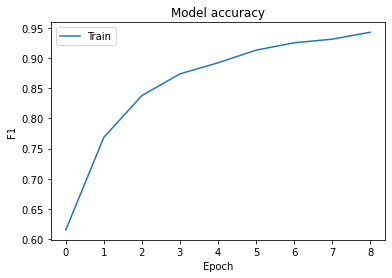

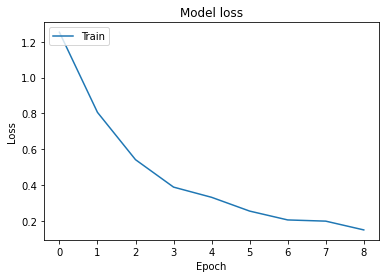

In [26]:
import warnings
warnings.filterwarnings('ignore')

root_path = 'data_21102022_ready'
exp_path = os.path.join(root_path,'experiments')
save_path = os.path.join(exp_path,exp_name)

# USE THIS ON WINDOWS
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.InteractiveSession(config=config)

full_path = os.path.join(root_path,'data_all')
training = os.path.join(full_path,'training')

mod_name = f'ResNet50_full_model'

nb_train_samples = len(os.listdir(training))

train_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    training,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_type)
print(train_generator)

base_model = ResNet50(input_shape = input_shape, include_top = False, weights = 'imagenet')

base_model.trainable = False
x = layers.Flatten()(base_model.output)
x = layers.Dense(layer_size, activation='relu')(x)
x = layers.Dense(layer_size, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(nclasses, activation=activation_fun)(x)
model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = Adam(lr=learning_rate), loss=loss_type, 
              metrics=[Precision(),Recall(),f1_weighted,f1_macro,f1_adjusted], run_eagerly=True)

# train the model with frozen layers
history = model.fit_generator(train_generator, 
    steps_per_epoch=nb_train_samples // batch_size, 
    epochs=epochs, 
    class_weight = weights)

F1_weighted = history.history['f1_weighted']
F1_macro = history.history['f1_macro']
prec = history.history['precision']
rec = history.history['recall']
loss = history.history['loss']

train_dev = {'F1_weighted':F1_weighted,
             'F1_macro':F1_macro,
             'precision':prec,
             'recall':rec,
             'loss':loss}

df_train_dev = pd.DataFrame.from_dict(train_dev)
csv_name = f'data_full_model.csv'
save_csv = os.path.join(save_path,csv_name)
df_train_dev.to_csv(save_csv, index=False)


base_model.trainable = True
model.compile(optimizer = Adam(lr=0.0001), loss=loss_type, metrics=[Precision(),Recall(),f1_weighted,f1_macro,f1_adjusted], run_eagerly=True)

# train the model with unfrozen layers
history = model.fit_generator(train_generator, 
steps_per_epoch=nb_train_samples // batch_size, 
epochs=epochs, 
callbacks=callbacks2,
class_weight = weights)
validation_data = validation_generator, 
validation_steps=nb_validation_samples // batch_size)

# visualize learning curves
plt.plot(F1_weighted)
plt.title('Model accuracy')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.savefig(os.path.join(save_path,'accuracy_full_model.png'))
plt.show()
plt.close()

plt.plot(loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.savefig(os.path.join(save_path,f'loss_full_model.png'))
plt.show()
plt.close()


model.save(os.path.join(save_path,mod_name+'.h5'))
del model
tf.keras.backend.clear_session()

## Predict on unseen data

In [28]:
root_path = 'data_21102022_ready'
exp_path = os.path.join(root_path,'experiments')
exp_name = experiments[3]
print(exp_name)
save_path = os.path.join(exp_path,exp_name)
mod_name = f'ResNet50_full_model'
full_path = os.path.join(root_path,'data_all')

CV_ls_198_bs_16_lr_9e-05_dr_0.5_ep_100_pat_15


In [29]:
test_data_dir = os.path.join(full_path,'test')

In [30]:
model_path =  os.path.join(save_path,mod_name+'.h5')
# r'C:\Users\vibane\Desktop\Victor\Victor_ML\RiFNetII_nr_m1_noweight.h5'
from tensorflow.keras.optimizers import Adam 
opt = Adam(lr=learning_rate)
dependencies = {
    'f1_adjusted': f1_adjusted
}
loaded_model = tf.keras.models.load_model(model_path, custom_objects=dependencies, compile=False)
loaded_model.compile(loss=loss_type,
                  optimizer=opt,
                  metrics=[Precision(),Recall(),f1_adjusted], run_eagerly=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

print(test_generator)
print(test_generator.class_indices)

Found 18262 images belonging to 5 classes.
{'displaced_latus': 0, 'displaced_long_cum_cont': 1, 'displaced_long_cum_dist': 2, 'no_fracture': 3, 'nondisplaced': 4}


In [32]:
pred= loaded_model.predict_generator(test_generator)#, nb_validation_samples // batch_size)
y_pred=np.argmax(pred,axis=1)
y_true = test_generator.classes

UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [220]:
print(len(y_pred))
print(len(y_true))

18262
18262


In [222]:
def f1_weighted(y_true, y_pred):
    
    F1 = f1_score(y_true, y_pred, average='weighted')
    
    return F1

In [223]:
score = f1_weighted(y_true,y_pred)
print('{:.4f} F1_adjusted'.format(score))

0.8400 F1_adjusted


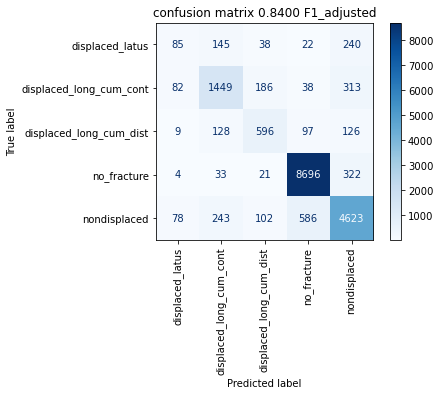

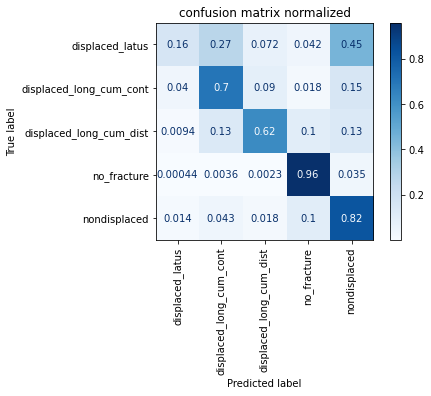

In [224]:
# calculate and plot confusion matrix

#class_labels = ['buckle','displaced','no_fracture','nondisplaced','nondisplaced_consolidated','nondisplaced_nonunion','nondisplaced_single'] 
#class_labels = ['buckle','displaced','no_fracture','nondisplaced','nondisplaced_single'] 
#class_labels = ['buckle','displaced','no_fracture','nondisplaced']
#class_labels = ['displaced','no_fracture','nondisplaced'] 
class_labels = classes
mod_name = os.path.basename(model_path).split('.')[0]

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix' + ' {:.4f} F1_adjusted'.format(score))
plt.xticks(ticks=None, labels=None, rotation=90)
#plt.savefig(target_dir + mod_name + '_abs.png')
plt.show()
plt.close()

cm = confusion_matrix(test_generator.classes, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix normalized')
plt.xticks(ticks=None, labels=None, rotation=90)
#plt.savefig(target_dir + mod_name + '_rel.png')
plt.show()
plt.close()

In [225]:
classes = natsorted(os.listdir(test_data_dir))
classes

['displaced_latus',
 'displaced_long_cum_cont',
 'displaced_long_cum_dist',
 'no_fracture',
 'nondisplaced']

Here we want to get aggregated scores for single fractures. We also calculate correlations from human prediction to the models prediction.

In [226]:
import cv2
from collections import Counter

tot_recall_classes = []
tot_recall_fractures = []
tot_missed_classes = []
tot_missed_fractures = []
tot_fractures = []
tot_scores = []
confused = []
missed = []
tot_human_scores = []
missed_human_scores = []
confused_human_scores = []
match_displaced = 0
no_match_displaced = 0
predicted = []
truth = []

for cl in range(len(classes)):
    
    current_class = classes[cl]
    print('current class:',current_class)
    
    if classes[cl] == 'no_fracture':
        continue
        
    candidates =  natsorted(os.listdir(os.path.join(test_data_dir,classes[cl])))
    candidates = [os.path.join(test_data_dir,classes[cl],x) for x in candidates]
    cand_pack = pack(candidates)
    tot_fractures.append(len(cand_pack))
    
    missed_fractures = 0
    missed_classes = 0
    
    clean_classes = classes.copy()
    no_frac = classes.index('no_fracture')
    clean_classes.pop(no_frac)
    
    for i in clean_classes:
        if i != current_class:
            index_other = classes.index(i)
            
    human_scores = []
    scores = []
    
    for frac in cand_pack:
        
        human_score = int(frac[0].split('.')[0].split('\\')[-1][-1])
        human_scores.append(human_score)   
        frac_imgs = [cv2.imread(img, cv2.IMREAD_UNCHANGED) for img in frac]
        frac_imgs = np.array([x/255. for x in frac_imgs])
        pred = loaded_model.predict(frac_imgs)
        y_pred = list(np.argmax(pred,axis=1))
        t = Counter(y_pred)
        winner_class = max(t, key=t.get)
        #print(t, winner_class)
        if winner_class == no_frac and t[no_frac] != len(frac):
            t2 = {i:t[i] for i in t if i!=winner_class}
            second_class = max(t2, key=t.get)
        nb_current_class = t[cl]
        #nb_other_class = y_pred.count(index_other)
        score_current_class = nb_current_class/len(frac)
        scores.append(score_current_class)
        truth.append(cl)
        
        if winner_class != cl:
            # if winner class no frac but others as well
            if winner_class == no_frac and t[no_frac] != len(frac):
                missed_name = frac[0].split('.')[0].split('\\')[-1][:-4]
                missed_human_score = frac[0].split('.')[0].split('\\')[-1][-1]
                confused.append(str(classes[cl])+'_'+missed_name)
                predicted.append(second_class)
                confused_human_scores.append(missed_human_score)
                #print('confused fracture of class "{}" for class "{}":'.format(classes[cl],classes[index_other]),missed_name)
                missed_classes += 1
                
            # if winner class other class
            if winner_class != no_frac:
                missed_name = frac[0].split('.')[0].split('\\')[-1][:-4]
                missed_human_score = frac[0].split('.')[0].split('\\')[-1][-1]
                confused.append(str(classes[cl])+'_'+missed_name)
                predicted.append(winner_class)
                confused_human_scores.append(missed_human_score)
                #print('confused fracture of class "{}" for class "{}":'.format(classes[cl],classes[index_other]),missed_name)
                missed_classes += 1 
            
            # if winner class all no frac
            if t[no_frac] == len(frac):  
                missed_name = frac[0].split('.')[0].split('\\')[-1][:-4]
                missed_human_score = frac[0].split('.')[0].split('\\')[-1][-1]
                missed.append(str(classes[cl])+'_'+missed_name)
                missed_human_scores.append(missed_human_score)
                #print('entirely missed fracture of class "{}":'.format(classes[cl]),missed_name)
                missed_fractures += 1
                predicted.append(no_frac)
        
        if classes[cl].split('_')[0] == 'displaced':
            if winner_class in (0,1,2):
                match_displaced += 1
            else:
                no_match_displaced += 1
        
        if winner_class == cl:
            predicted.append(winner_class)
        
        #print(truth)
        #print(predicted)
    
    human_scores =[round(x/3,2) for x in human_scores]
    tot_human_scores.append(human_scores)
    recall_fractures = round(1-(missed_fractures/len(cand_pack)),4)
    tot_recall_fractures.append(recall_fractures)
    tot_missed_classes.append(missed_classes)
    recall_classes = round(1-(missed_classes/len(cand_pack)),4)
    tot_recall_classes.append(recall_classes)
    tot_scores.append(scores)
    tot_missed_fractures.append(missed_fractures)
    r = np.corrcoef(human_scores, scores)
    corr = r[0, 1]
    print('correlation human - tool:', corr)
    print('--> Missed {} fractures entirely'.format(missed_fractures))
    print('--> Recall detecting a fracture in the class "{}":'.format(classes[cl]),recall_classes)
    
print('')
print('--> Overall matches displaced: {}'.format(match_displaced/(match_displaced+no_match_displaced)))
print('--> Overall fractures undetected ignoring the classes: {} of a total of: {}'.format(sum(tot_missed_fractures),sum(tot_fractures)))
print('--> Overall recall detecting a fracture ignoring the classes:',sum(tot_recall_fractures)/len(tot_recall_fractures))
print('')
print('--> Overall fractures undetected from a certain fracture type: {} of a total of: {}'.format(sum(tot_missed_classes),sum(tot_fractures)))
print('--> Overall recall detecting a certain fracture type:',sum(tot_recall_classes)/len(tot_recall_classes))




current class: displaced_latus
correlation human - tool: 0.05297706930935944
--> Missed 0 fractures entirely
--> Recall detecting a fracture in the class "displaced_latus": 0.1471
current class: displaced_long_cum_cont
correlation human - tool: 0.45700696179770994
--> Missed 0 fractures entirely
--> Recall detecting a fracture in the class "displaced_long_cum_cont": 0.7252
current class: displaced_long_cum_dist
correlation human - tool: 0.18920633259067907
--> Missed 1 fractures entirely
--> Recall detecting a fracture in the class "displaced_long_cum_dist": 0.6984
current class: no_fracture
current class: nondisplaced
correlation human - tool: 0.19309574198147028
--> Missed 4 fractures entirely
--> Recall detecting a fracture in the class "nondisplaced": 0.8692

--> Overall matches displaced: 0.7850877192982456
--> Overall fractures undetected ignoring the classes: 5 of a total of: 595
--> Overall recall detecting a fracture ignoring the classes: 0.9933

--> Overall fractures undetect

In [238]:
candidates_no =  natsorted(os.listdir(os.path.join(test_data_dir,'no_fracture')))
candidates_no = [os.path.join(test_data_dir,'no_fracture',x) for x in candidates_no]
for img in candidates_no:
    no_frac_img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    no_frac_img = np.expand_dims(no_frac_img, axis=0)
    no_frac_img = np.array(no_frac_img/255.)
    pred = loaded_model.predict(no_frac_img)
    y_pred = list(np.argmax(pred,axis=1))
    t = Counter(y_pred)
    winner_class = max(t, key=t.get)


In [ ]:
winner_class

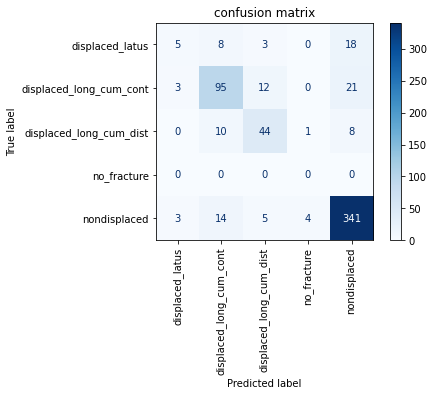

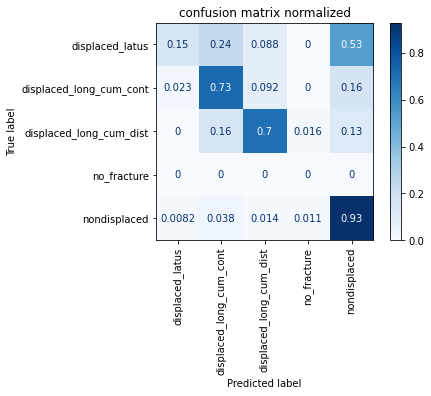

In [228]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(truth, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.xticks(ticks=None, labels=None, rotation=90)
plt.savefig(os.path.join(save_path,mod_name+'conf_matrix.png'))
plt.show()
plt.close()

cm = confusion_matrix(truth, predicted,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix normalized')
plt.xticks(ticks=None, labels=None, rotation=90)
plt.savefig(os.path.join(save_path,mod_name+'conf_matrix_relative.png'))
plt.show()
plt.close()

In [193]:
total_fracs = sum(tot_fractures)
acc_missed = round(1-(len(missed)/total_fracs),3)
acc_confused = round(1-(len(confused)/total_fracs),3)

print('accuracy of detecting fractures:',acc_missed,'/ accuracy of detecting fracture types:', acc_confused)

accuracy of detecting fractures: 0.993 / accuracy of detecting fracture types: 0.768


In [194]:
print(missed)
print(missed_human_scores)
nb_list = [int(x) for x in missed_human_scores]
print(np.mean(nb_list))

['displaced_long_cum_dist_fracture_194_8', 'nondisplaced_fracture_209_4', 'nondisplaced_fracture_210_12', 'nondisplaced_fracture_210_34']
['1', '2', '1', '1']
1.25


In [195]:
print(confused)
print(confused_human_scores)
nb_list = [int(x) for x in confused_human_scores]
print(np.mean(nb_list))

['displaced_latus_fracture_181_21', 'displaced_latus_fracture_182_1', 'displaced_latus_fracture_182_4', 'displaced_latus_fracture_182_6', 'displaced_latus_fracture_182_9', 'displaced_latus_fracture_182_10', 'displaced_latus_fracture_183_1', 'displaced_latus_fracture_183_6', 'displaced_latus_fracture_183_10', 'displaced_latus_fracture_194_9', 'displaced_latus_fracture_195_10', 'displaced_latus_fracture_196_7', 'displaced_latus_fracture_198_9', 'displaced_latus_fracture_200_2', 'displaced_latus_fracture_202_10', 'displaced_latus_fracture_206_2', 'displaced_latus_fracture_206_3', 'displaced_latus_fracture_207_1', 'displaced_latus_fracture_208_3', 'displaced_latus_fracture_210_35', 'displaced_latus_fracture_211_25', 'displaced_latus_fracture_211_39', 'displaced_latus_fracture_220_3', 'displaced_latus_fracture_230_6', 'displaced_latus_fracture_235_8', 'displaced_latus_fracture_248_1', 'displaced_latus_fracture_254_2', 'displaced_latus_fracture_254_4', 'displaced_long_cum_cont_fracture_196_1

In [196]:
nb = mod_name.split('_')[-1]
dic = {'iteration':nb,'missed':missed,'missed_score':missed_human_scores,
       'confused':confused,'confused_score':confused_human_scores,
       'total_fractures':total_fracs,'certainty_displaced':tot_scores[0],
       'certainty_nondisplaced':tot_scores[1],'human_displaced':tot_human_scores[0],
      'human_nondisplaced':tot_human_scores[1]}

In [197]:
import pandas as pd
df_prediction = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dic.items() ]))
df_prediction.head()

,iteration,missed,missed_score,confused,confused_score,total_fractures,certainty_displaced,certainty_nondisplaced,human_displaced,human_nondisplaced
0,model,displaced_long_cum_dist_fracture_194_8,1,displaced_latus_fracture_181_21,2,595.0,0.000000,0.812500,0.67,1.00
1,NaN,nondisplaced_fracture_209_4,2,displaced_latus_fracture_182_1,1,NaN,0.000000,1.000000,0.33,1.00
2,NaN,nondisplaced_fracture_210_12,1,displaced_latus_fracture_182_4,3,NaN,0.000000,0.941176,1.00,1.00
3,NaN,nondisplaced_fracture_210_34,1,displaced_latus_fracture_182_6,2,NaN,0.058824,1.000000,0.67,1.00
4,NaN,NaN,NaN,displaced_latus_fracture_182_9,1,NaN,0.000000,0.800000,0.33,0.33


In [198]:
save_csv = save_path + '_prediction_' + mod_name +'.csv'
df_prediction.to_csv(save_csv, index=False)

In [199]:
tot_list = [missed, missed_human_scores, confused, confused_human_scores]
names = ['missed','confused']

In [200]:
data_save_path = save_path + '_missclassified'
if not os.path.isdir(data_save_path):
    os.makedirs(data_save_path)
    
for i in range(0,len(tot_list),2):
    
    current_accuracy_type = names[int(i/2)]
    current_path = os.path.join(data_save_path,current_accuracy_type) 
    
    if not os.path.isdir(current_path):
        os.makedirs(current_path)
        
    current_list = tot_list[i]
    current_scores = tot_list[i+1]
    
    for s in range(len(current_list)):
        
        parts =  current_list[s].split('_')
        for c in classes:
            if c in current_list[s]:
                current_class = c
        #current_class = parts[0]
        real_sample = 'fracture_' + parts[-2]+'_'+parts[-1]+'_'+'1'+'_'+current_scores[s]
        real_sample_old_path = os.path.join(test_data_dir,current_class,real_sample+'.jpg')
        real_sample_new_path = os.path.join(current_path,current_list[s]+'_'+current_scores[s]+'.jpg')
        shutil.copy(real_sample_old_path, real_sample_new_path)

Text(0.5, 0.98, 'Machine certainty distribution for each fracture class')

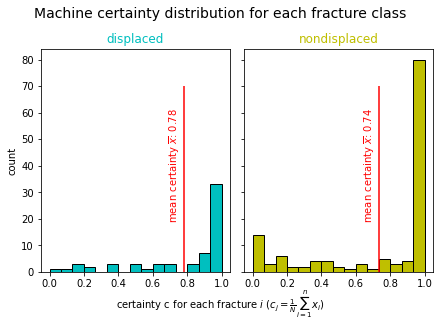

In [230]:
# plot distribution of fracture certainty for each class
n_bins = 15
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
axs[0].hist(tot_scores[0], bins=n_bins, color='c',histtype='bar', ec='black')
axs[1].hist(tot_scores[1], bins=n_bins, color='y',histtype='bar', ec='black')
axs[0].set_title(classes[0], color='c')
axs[1].set_title(classes[2], color='y')
axs[0].set_ylabel('count')
axs[0].vlines(np.mean(tot_scores[0]),0,70,color='r')
axs[1].vlines(np.mean(tot_scores[1]),0,70,color='r')
axs[0].text(np.mean(tot_scores[0])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_scores[0]),2)),color='r',rotation=90)
axs[1].text(np.mean(tot_scores[1])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_scores[1]),2)),color='r',rotation=90)
fig.text(0.5, -0.06, r'certainty c for each fracture $i$ ($c_j = \frac{1}{N} \sum_{i=1}^n x_i$)', ha='center')
fig.suptitle('Machine certainty distribution for each fracture class', fontsize=14, ha='center')


Text(0.5, 0.98, 'Human certainty distribution for each fracture class')

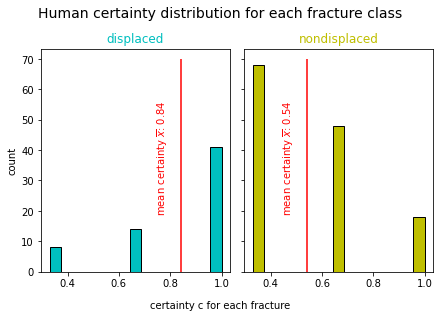

In [231]:
# plot distribution of fracture certainty for each class
n_bins = 15
fig, axs = plt.subplots(1, 2, sharey=True, constrained_layout=True)
axs[0].hist(tot_human_scores[0], bins=n_bins, color='c',histtype='bar', ec='black')
axs[1].hist(tot_human_scores[1], bins=n_bins, color='y',histtype='bar', ec='black')
axs[0].set_title(classes[0], color='c')
axs[1].set_title(classes[2], color='y')
axs[0].set_ylabel('count')
axs[0].vlines(np.mean(tot_human_scores[0]),0,70,color='r')
axs[1].vlines(np.mean(tot_human_scores[1]),0,70,color='r')
axs[0].text(np.mean(tot_human_scores[0])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_human_scores[0]),2)),color='r',rotation=90)
axs[1].text(np.mean(tot_human_scores[1])-0.1,20,'mean certainty $\overline{x}$: '+str(round(np.mean(tot_human_scores[1]),2)),color='r',rotation=90)
fig.text(0.5, -0.06, r'certainty c for each fracture', ha='center')
fig.suptitle('Human certainty distribution for each fracture class', fontsize=14, ha='center')